# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## 0. Import all needed packages and libraries

In [706]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


from time import time

from sklearn.tree import DecisionTreeClassifier 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1. Data Understanding

### Portfolio Dataset

In [710]:
# show dataset
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [711]:
# looking for null values
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [712]:
# get shape
portfolio.shape

(10, 6)

Text(0,0.5,'Amount')

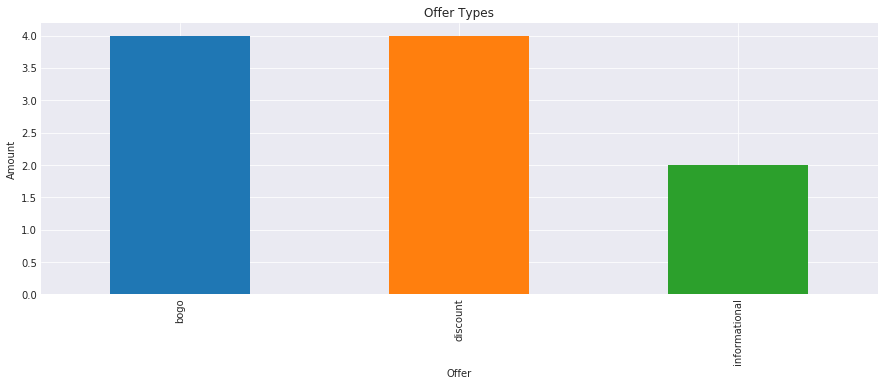

In [713]:
# visualisiation of different offer types
graph_portfolio = portfolio["offer_type"].value_counts().plot.bar(figsize=(15,5))

graph_portfolio.set_title("Offer Types")
graph_portfolio.set_xlabel("Offer")
graph_portfolio.set_ylabel("Amount")

#### Findings
As expected, the portfolio dataframe is clean. There are no missing values. The shape of the data frame is (10,6). 

Data preparation:

- Transofrm the channels column and seperate the entries to single, binary columns
- Prepare date for ML

### Profile Dataset

In [714]:
# show dataset
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [715]:
# looking for null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [716]:
# get shape
profile.shape

(17000, 5)

In [717]:
# analyze entries with NaNs
profile[profile.isna().any(axis=1)]

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


Text(0,0.5,'Amount')

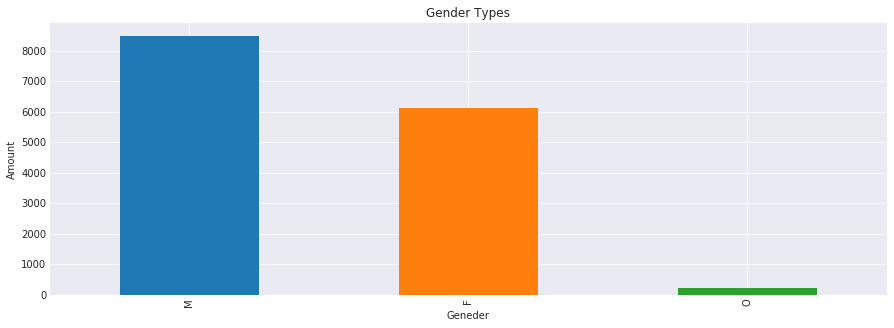

In [718]:
# visualize and understand profile dataset

# focus on gender
profile_gender = profile["gender"].value_counts().plot.bar(figsize=(15,5))

profile_gender.set_title("Gender Types")
profile_gender.set_xlabel("Geneder")
profile_gender.set_ylabel("Amount")


Text(0,0.5,'Count')

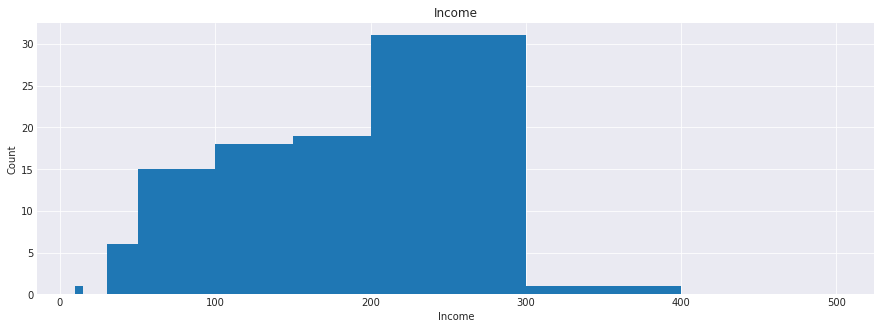

In [719]:
# focus on income
profile_income = profile["income"].value_counts().plot.hist(bins=[10,15,20, 30, 50, 100, 150, 200, 300, 400, 500], figsize=(15,5))

profile_income.set_title("Income")
profile_income.set_xlabel("Income")
profile_income.set_ylabel("Count")

Text(0,0.5,'Count')

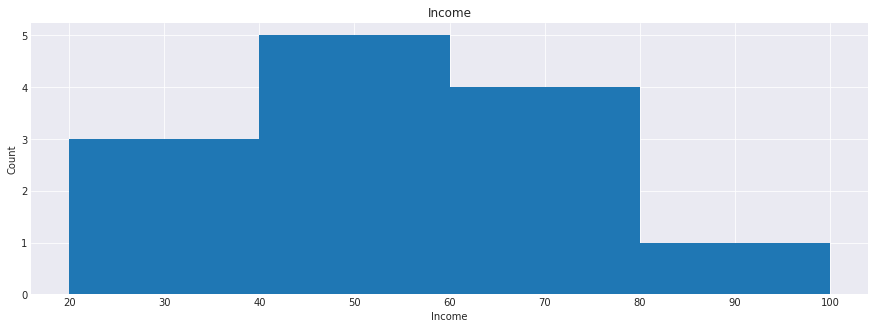

In [720]:
# focus on age
profile_age = profile["age"].value_counts().plot.hist(bins=[20,40,60,80,100], figsize=(15,5))

profile_age.set_title("Income")
profile_age.set_xlabel("Income")
profile_age.set_ylabel("Count")

#### Findings
The profile data set has a shape of (17000, 5). The data set contains 2175 NaNs wich all show the same pattern. There are no gender and income related information. All of the NaN entries show an age of 118.

Data preparation:
 
- Convert became_member_on column to datetime 
- Delete all rows with NANs as these can not be used for ML
- Prepare data for ML

## Transcript Dataset

In [535]:
# show data set
transcript.head(5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [536]:
# shape
transcript.shape

(306534, 4)

In [537]:
# check for NaNs
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

#### Findings
The transcript data set has a shape of (306534, 4). This menas, that more than 300.000 transactions were recorded. The data set contains no NaNs. 

Data preparation:
 
- Convert became_member_on column to datetime 
- Delete all rows with NANs as these can not be used for ML
- Prepare data for ML

## 2. Data Cleaning

### Portfolio Dataset
Encode categorical features as a one-hot numeric array

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html and
https://stackoverflow.com/questions/6986986/bin-size-in-matplotlib-histogram

In [721]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [722]:
def prepare_portfolio (df = portfolio):
    '''
    Args:
    df: Data Frame. Data Frame containg information such as channel, diffuculty, duration, id ,offer_type and reward
       
    Returns:
    df: Data Frame. One hot encoded data frame
    
    '''
    
    # hot encode channels columns
    channels = portfolio['channels'].str.join(sep=',').str.get_dummies(sep=',')
    
    # get dummies for offer_type
    offer = pd.get_dummies(portfolio['offer_type'])
    
    # concat original portfolio df with hot encoded channels and offer df
    portfolio_edit = pd.concat([df, channels, offer], axis = 1, sort = False)
    
    # Drop columns channel and offer_type
    portfolio_edit = portfolio_edit.drop(['channels', 'offer_type'], axis=1)
    
    
    return portfolio_edit

In [723]:
portfolio_edit = prepare_portfolio(portfolio)

### Profile Data Set

In [724]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [725]:
def prepare_profile (df = profile):
    '''
    Args:
    df: Data Frame. Data Frame containg information such as age, became_member_on, gender, id and income
       
    Returns:
    df: Data Frame. Encoded categorical features as a one-hot numeric array
    
    '''
    profile_edit = profile
    
    # Get dummies for geneder
    gender = pd.get_dummies(profile_edit['gender'])
    
    # Create bins for age
    ages_bins = pd.cut(x=profile_edit["age"], bins=[18, 20, 25, 29, 35, 39, 49, 59, 69, 79, 89, 99, 102])
    
    # Get dummies for age
    ages = pd.get_dummies(ages_bins)
    
    # Create bins for income
    income_bins = pd.cut(x=profile_edit["income"], bins=[20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000])
    
    # Get dummies for age
    income = pd.get_dummies(income_bins)
    
    # concat original profile df with hot encoded df
    profile_edit = pd.concat([df, gender, ages, income], axis = 1, sort = False)
    
    # Drop Rows with  NaNs in income
    profile_edit = profile_edit.drop(profile[(profile["income"].isnull())].index)
    
    # Drop columns age, gender, became_member_on and income
    profile_edit = profile_edit.drop(['age', 'gender', 'income', 'became_member_on'], axis=1)
    
    return profile_edit

In [726]:
profile_edit = prepare_profile(profile)

In [727]:
# Check for NaNs
profile_edit.isnull().sum()

id                  0
F                   0
M                   0
O                   0
(18, 20]            0
(20, 25]            0
(25, 29]            0
(29, 35]            0
(35, 39]            0
(39, 49]            0
(49, 59]            0
(59, 69]            0
(69, 79]            0
(79, 89]            0
(89, 99]            0
(99, 102]           0
(20000, 30000]      0
(30000, 40000]      0
(40000, 50000]      0
(50000, 60000]      0
(60000, 70000]      0
(70000, 80000]      0
(80000, 90000]      0
(90000, 100000]     0
(100000, 110000]    0
(110000, 120000]    0
dtype: int64

### Transcript Data Set

In [728]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [729]:
# Find keys in value column 
values = set()
for i in transcript.value:
    values.update(set(i.keys()))

values

{'amount', 'offer id', 'offer_id', 'reward'}

In [730]:
def get_offer_id(dict_val):
    
    """
    Args:
    dict_val: dictionary. Dictionary from transcript['value'] column
    
    OUTPUT:
    value_offer_id: object. - value of the offer_id or offer id column
    """
    
    for i in ["offer_id", "offer id"]:
        if i in dict_val:
            value_offer_id = dict_val[i]
            break
    else:
        value_offer_id = np.nan
    
    return value_offer_id

def prepare_transcript(transcript):
    
    '''
    Args:
    df: Data Frame. Trascript Data Frame
       
    Returns:
    df: Data Frame. trasctipt_edit with seperated offer_id
    
    '''
    
    # Create offer_id column
    transcript["offer_id"] = transcript['value'].apply(get_offer_id)
    
    #  Get dummies for event column
    event = pd.get_dummies(transcript['event'])
    
    
    # concat original trascipt df with hot encoded df
    transcript_edit = pd.concat([transcript, event], axis=1, sort=False)
    
    # drop transaction column
    #transcript_edit = transcript_edit.drop(transaction.index)
    transcript_edit = transcript_edit.drop(['value', 'transaction', 'event'], axis=1)
    
    
    return transcript_edit

In [731]:
transcript_edit = prepare_transcript(transcript)
transcript_edit.head()

,person,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0


## 3. Data Exploration

In [732]:
portfolio_edit.head()

,difficulty,duration,id,reward,email,mobile,social,web,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0


In [733]:
profile_edit.head()

,id,F,M,O,"(18, 20]","(20, 25]","(25, 29]","(29, 35]","(35, 39]","(39, 49]",...,"(20000, 30000]","(30000, 40000]","(40000, 50000]","(50000, 60000]","(60000, 70000]","(70000, 80000]","(80000, 90000]","(90000, 100000]","(100000, 110000]","(110000, 120000]"
1,0610b486422d4921ae7d2bf64640c50b,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,e2127556f4f64592b11af22de27a7932,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,389bc3fa690240e798340f5a15918d5c,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
12,2eeac8d8feae4a8cad5a6af0499a211d,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [734]:
transcript_edit.head()

,person,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0


In [735]:
# Rename id column to offer_id in portfolio_edit df
portfolio_edit = portfolio_edit.rename(columns={"id": "offer_id" })
# Merge portfolio_edit and transcript_edit
df_total = transcript_edit.merge(portfolio_edit[portfolio_edit.columns])
df_total.head()
# rename id column to person in profile_edit df
profile_edit = profile_edit.rename(columns={"id": "person" })
# Merge profile_edit with df_total
df_total = df_total.merge(profile_edit[profile_edit.columns])
df_total.columns

Index([         'person',            'time',        'offer_id',
       'offer completed',  'offer received',    'offer viewed',
            'difficulty',        'duration',          'reward',
                 'email',          'mobile',          'social',
                   'web',            'bogo',        'discount',
         'informational',               'F',               'M',
                     'O',          (18, 20],          (20, 25],
                (25, 29],          (29, 35],          (35, 39],
                (39, 49],          (49, 59],          (59, 69],
                (69, 79],          (79, 89],          (89, 99],
               (99, 102],    (20000, 30000],    (30000, 40000],
          (40000, 50000],    (50000, 60000],    (60000, 70000],
          (70000, 80000],    (80000, 90000],   (90000, 100000],
        (100000, 110000],  (110000, 120000]],
      dtype='object')

In [736]:
# Rename Columns
column_names = [ 'person','time','offer_id', 'offer_completed', 'offer_received', 'offer_viewed', 'difficulty','duration','reward','email', 'mobile','social','web','bogo','discount','informational','F','M','O','18-20','20-25','25-29','29-35','35-39','39-49', '49-59','59-69','69-79','79-89','89-99','99-102','20K-30K', '30K-40K','40K-50K', '50K-60K','60K-70K', '70K-80K','80K-90K','90K-100K', '100K-110K','110K-120K']

In [737]:
df_total.columns = column_names

In [738]:
df_total.head()

,person,time,offer_id,offer_completed,offer_received,offer_viewed,difficulty,duration,reward,email,...,20K-30K,30K-40K,40K-50K,50K-60K,60K-70K,70K-80K,80K-90K,90K-100K,100K-110K,110K-120K
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,5,7,5,1,...,0,0,0,0,0,0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,5,7,5,1,...,0,0,0,0,0,0,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,5,7,5,1,...,0,0,0,0,0,0,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,5,5,5,1,...,0,0,0,0,0,0,0,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,5,5,5,1,...,0,0,0,0,0,0,0,1,0,0


In [739]:
# Final check
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 41 columns):
person             148805 non-null object
time               148805 non-null int64
offer_id           148805 non-null object
offer_completed    148805 non-null uint8
offer_received     148805 non-null uint8
offer_viewed       148805 non-null uint8
difficulty         148805 non-null int64
duration           148805 non-null int64
reward             148805 non-null int64
email              148805 non-null int64
mobile             148805 non-null int64
social             148805 non-null int64
web                148805 non-null int64
bogo               148805 non-null uint8
discount           148805 non-null uint8
informational      148805 non-null uint8
F                  148805 non-null uint8
M                  148805 non-null uint8
O                  148805 non-null uint8
18-20              148805 non-null uint8
20-25              148805 non-null uint8
25-29              148805 

### Analyze offer usage by user groups

In [740]:
# General style
sns.set_style('darkgrid')

Text(0,0.5,'Amount')

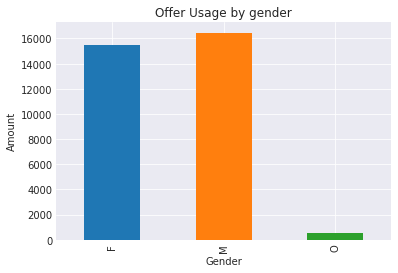

In [741]:
# Analysis by gender
gender_dist = df_total[df_total['offer_completed']==1][['F','M','O']].sum().plot.bar(fontsize=10) 
gender_dist.set_title("Offer Usage by gender")
gender_dist.set_xlabel("Gender")
gender_dist.set_ylabel("Amount")

Text(0,0.5,'Amount')

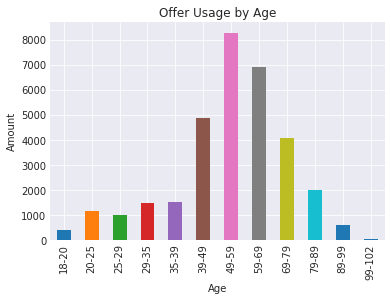

In [742]:
# Analysis by age
age_columns = ['18-20','20-25','25-29','29-35','35-39','39-49', '49-59','59-69','69-79','79-89','89-99','99-102']
age_dist = df_total[df_total['offer_completed']==1][age_columns].sum().plot.bar(fontsize=10) 
age_dist.set_title("Offer Usage by Age")
age_dist.set_xlabel("Age")
age_dist.set_ylabel("Amount")

Text(0,0.5,'Amount')

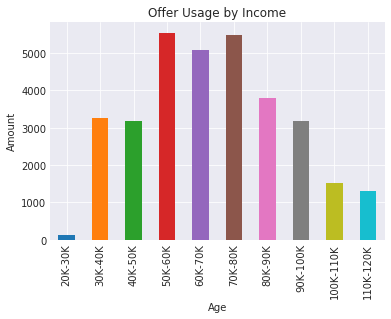

In [743]:
# Analysis by income
income_columns = ['20K-30K', '30K-40K','40K-50K', '50K-60K','60K-70K', '70K-80K','80K-90K','90K-100K', '100K-110K','110K-120K']
income_dist = df_total[df_total['offer_completed']==1][income_columns].sum().plot.bar(fontsize=10) 
income_dist.set_title("Offer Usage by Income")
income_dist.set_xlabel("Age")
income_dist.set_ylabel("Amount")

Text(0,0.5,'Amount')

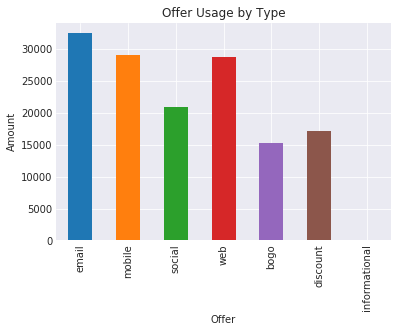

In [744]:
# Analysis by offer type
type_columns = ['email', 'mobile','social','web','bogo','discount','informational']
type_dist = df_total[df_total['offer_completed']==1][type_columns].sum().plot.bar(fontsize=10) 
type_dist.set_title("Offer Usage by Type")
type_dist.set_xlabel("Offer")
type_dist.set_ylabel("Amount")

Text(0,0.5,'Amount')

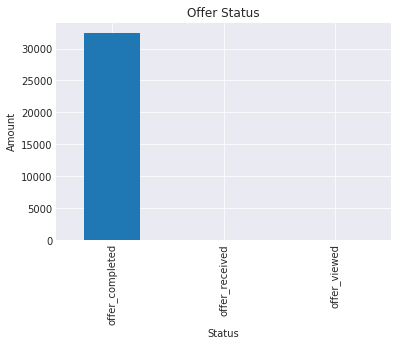

In [745]:
# Analysis by offer status
offerstatus_columns = ['offer_completed', 'offer_received', 'offer_viewed']
offerstatus_dist = df_total[df_total['offer_completed']==1][offerstatus_columns].sum().plot.bar(fontsize=10) 
offerstatus_dist.set_title("Offer Status")
offerstatus_dist.set_xlabel("Status")
offerstatus_dist.set_ylabel("Amount")

#### Findings
1) Most offers are completed by males

2) Most users are that complete offers are in the age of 49-59

3) The average income of useres who complete offers is between 50K-80K

## 4. Machine Learning Model for order completion prediction

In the following, a Machine Learning Model to predict order completion will be build. Before the model can be built, some addtional Data Preperatation and Normalization is necessary.

### Data Preparation II

In [746]:
# Drop columns that are not needed
df_total = df_total.drop(["offer_received", 'offer_viewed', 'informational'], axis=1)

In [747]:
df_total.columns

Index(['person', 'time', 'offer_id', 'offer_completed', 'difficulty',
       'duration', 'reward', 'email', 'mobile', 'social', 'web', 'bogo',
       'discount', 'F', 'M', 'O', '18-20', '20-25', '25-29', '29-35', '35-39',
       '39-49', '49-59', '59-69', '69-79', '79-89', '89-99', '99-102',
       '20K-30K', '30K-40K', '40K-50K', '50K-60K', '60K-70K', '70K-80K',
       '80K-90K', '90K-100K', '100K-110K', '110K-120K'],
      dtype='object')

In [748]:
# Split data into feature and target
target = df_total[['offer_completed']]
features = df_total.drop('offer_completed', axis = 1)

In [749]:
# Change Column order
features = features[['person', 'offer_id', 'time', 'difficulty', 'duration', 'reward',
       'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'F', 'M', 'O',
       '18-20', '20-25', '25-29', '29-35', '35-39', '39-49', '49-59', '59-69',
       '69-79', '79-89', '89-99', '99-102', '20K-30K', '30K-40K', '40K-50K',
       '50K-60K', '60K-70K', '70K-80K', '80K-90K', '90K-100K', '100K-110K',
       '110K-120K']]

### Normalization of numerical features

In [752]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

numericals = features.columns[2:6]

features_minmax = pd.DataFrame(data = features)
features_minmax[numericals] = scaler.fit_transform(features[numericals])

# Show an example of a record with scaling applied
features_minmax.head(3)

,time,difficulty,duration,reward,email,mobile,social,web,bogo,discount,...,20K-30K,30K-40K,40K-50K,50K-60K,60K-70K,70K-80K,80K-90K,90K-100K,100K-110K,110K-120K
0,0.000000,0.25,0.571429,0.5,0.0,1.0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0.008403,0.25,0.571429,0.5,0.0,1.0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
2,0.184874,0.25,0.571429,0.5,0.0,1.0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [753]:
# Drop person and offer_id
features = features_minmax[features_minmax.columns[2:]]
features.head()

,duration,reward,email,mobile,social,web,bogo,discount,F,M,...,20K-30K,30K-40K,40K-50K,50K-60K,60K-70K,70K-80K,80K-90K,90K-100K,100K-110K,110K-120K
0,0.571429,0.5,0.0,1.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0.571429,0.5,0.0,1.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,0.571429,0.5,0.0,1.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0.285714,0.5,0.0,1.0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0.285714,0.5,0.0,1.0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0


### Split Train and Test Data on Classifiers

In [754]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.4, random_state = 1)

In [755]:
def train_test(clf):
    """  
    Args:
    Classifier: clf. Estimation with classifier
    Returns:
    train_f1: F1-Score for training Data
    test_f1: F1-Score for test Data       
    """
    
    train_prediction =  (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    
    # Compute F1-Score
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    
    # Get classifier
    name = clf.__class__.__name__
    
    return train_f1, test_f1, name

#### Random Forest Classifier

In [756]:
randomforest = RandomForestClassifier(random_state = 10);
rf_train_f1, rf_test_f1, randomforest = train_test(randomforest);

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


#### Decision Tree Classifier

In [757]:
decisiontree = DecisionTreeClassifier(random_state = 10)
dt_train_f1, dt_test_f1, decisiontree = train_test(decisiontree)

In [758]:
models = {'Model': [randomforest, decisiontree], 
          'train F1 score ':[rf_train_f1,dt_train_f1 ], 
          'test F1 score': [rf_test_f1, dt_test_f1],
         }
          
matrix = pd.DataFrame(models)

In [759]:
matrix

,Model,train F1 score,test F1 score
0,RandomForestClassifier,78.227658,77.875407
1,DecisionTreeClassifier,78.238858,77.999731


The comparison of Random Forest and Decision Tree Classifier shows, that the F1 Score in the test set of the Decision Tree Classifier is slighly better than the one of the Random Forest Classifier! However, both perform pretty good! The Decision Tree Classifier can be used for the classification purpose to predict if a order will be made or not!